# Comparative analysis of sentiment analysis algorithms

## Introduction

In this notebook we will perform a comparative analysis between various sentiment analysis approaches. 
The scope of this study is to compare out-of-the-box performance of various classifiers in order to establish some classifier baselines for future studies. To perform the comparison we will run various algorithms on a drug reviews data set and compute several metrics per classifier.

More specifically, we will compare the following approaches towards semntiment analysis:

* **Rule-based sentiment analysis:** For this approach we will compare two rule- and lexicon-based sentiment classifiers, i.e. *VADER* and *Textblob*

* **Feature-base sentiment analysis:** For this approach we will convert the reviews into features using TF-IDF scores and then train a standard ML classifier to peform sentiment analysis. Classifiers we will use are Naive Bayes, Logistic Regression and Support Vector Machines (SVMs)

* **Embedding-based sentiment analysis:** For this approach we will embed the review words using a pretrained language model and then use a transformer to perform sentiment analysis. The language model we will use or this analysis is DistilBERT model that was fine-tuned for sentiment analysis.

As evaluation metrics we will use *Precision*, *Recall*, *f1-score*, *AUC* and *Jaccard Index*, which we will compute for each classifier using the test data set. 

## Data Preprocessing

In [126]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
nltk.download('punkt')

from collections import defaultdict
from flair.models import TextClassifier
from flair.data import Sentence
from imblearn.under_sampling import RandomUnderSampler
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.pipeline import Pipeline
from textblob import TextBlob
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ClassPredictionError, ClassificationReport
from yellowbrick.classifier import ConfusionMatrix, ROCAUC
from yellowbrick.style import set_palette
from yellowbrick.style.palettes import PALETTES, SEQUENCES, color_palette
set_palette('yellowbrick')

pd.set_option('display.max_rows', 100)

%matplotlib inline

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Data Import

We will start our analysis by importing the drug reviews from json files.

In [128]:
def load_reviews(stage, file):
    # Loading data from multi-line jsonl files, so set 'lines=True'
    df = pd.read_json(file, lines=True).convert_dtypes()
    df = df.astype({col: 'int32' for col in df.select_dtypes('int64').columns})
    df['drugName'] = df['drugName'].astype('category')
    df['condition'] = df['condition'].astype('category')
    df['condition'] = df['condition'].str.replace('disorde', 'disorder') # Correct type in data set
    df.rename(columns={'usefulCount': 'useful_count', 'drugName': 'drug_name'}, inplace=True)
    df.set_index('patient_id',inplace=True)
    df.drop_duplicates(inplace=True, subset=['review'])
    print(f'Number of unique reviews in {stage} set:', df.shape[0])
    return(df)

In [129]:
train_df = load_reviews("training", "../data/drug_review_train.jsonl")
val_df = load_reviews("validation", "../data/drug_review_validation.jsonl")
test_df = load_reviews("test", "../data/drug_review_test.jsonl")

print(
    f"\n{train_df.shape[0] + val_df.shape[0] + test_df.shape[0]} unique drug reviews imported"
)


Number of unique reviews in training set: 84138
Number of unique reviews in validation set: 26054
Number of unique reviews in test set: 41467

151659 unique drug reviews imported


Let's quickly check that the data does not contain any NA values.

In [130]:
if sum([df.isna().sum()[1] for df in [train_df, val_df, test_df]])==0:
    print("No missing values found!")


No missing values found!


### Label creation

We will first preprocess our data and put it in a tidy format for subsequent analyses. To create training labels we will use the rating provided by the reviewer themselves. We will assign label *POSITIVE* to ratings greater or equal to 7 and NEGATIVE to ratings smaller than 7.

In [185]:
# Unicode strings for emoticons
HAPPY = "\U0001F642"
SAD = "\U0001F621"
STAR = "\U00002B50"

def preprocess_df(df):
    cols = [
        "drug_name",
        "condition",
        "review",
        "stars",
        "rating",
        "actual_sentiment",
        "actual_label",
        "date",
        "useful_count",
        "review_length",
    ]
    df["actual_label"] = ["POSITIVE" if x >=7 else "NEGATIVE" for x in df['rating'].tolist()]
    df["actual_label"] = df["actual_label"].astype("category")
    sentiment_labels = ["NEGATIVE", "POSITIVE"]
    df["actual_label"] = df["actual_label"].cat.reorder_categories(sentiment_labels)
    df["actual_sentiment"] = [HAPPY if x >=7 else SAD for x in df['rating'].tolist()]
    df["stars"] = [STAR * x for x in df["rating"].tolist()]
    df = df[cols]
    return df


train_df = preprocess_df(train_df)
val_df = preprocess_df(val_df)
test_df = preprocess_df(test_df)


In [132]:
test_df = test_df.head(1000)

After preprocessing we now have a column "actual_label", which is a binary variable that contains the sentiment labels, i.e "POSITIVE" or "NEGATIVE". We will use this column during training to train some of the classifier models and we will also use these labels during validation and testing to assess classifier performance.

To provided a quick, visual overview, we have also added some emoticons for the sentiment labels and ratings.
So, after preprocessing our data table looks as follows:

In [133]:
train_df.head(5)

,drug_name,condition,review,stars,rating,actual_sentiment,actual_label,date,useful_count,review_length
patient_id,,,,,,,,,,
89879,Cyclosporine,keratoconjunctivitis sicca,"""i have used restasis for about a year now and...",⭐⭐,2,😡,NEGATIVE,2013-04-20,69,147
143975,Etonogestrel,birth control,"""my experience has been somewhat mixed. i have...",⭐⭐⭐⭐⭐⭐⭐,7,🙂,POSITIVE,2016-08-07,4,136
106473,Implanon,birth control,"""this is my second implanon would not recommen...",⭐,1,😡,NEGATIVE,2016-05-11,6,140
184526,Hydroxyzine,anxiety,"""i recommend taking as prescribed, and the bot...",⭐⭐⭐⭐⭐⭐⭐⭐⭐⭐,10,🙂,POSITIVE,2012-03-19,124,104
91587,Dalfampridine,multiple sclerosis,"""i have been on ampyra for 5 days and have bee...",⭐⭐⭐⭐⭐⭐⭐⭐⭐,9,🙂,POSITIVE,2010-08-01,101,74


## Create training, validation and test sets

To facilitate model building and evaluation, we will extract features and labels for the train, validation and test sets.

In [134]:
X_train = train_df['review']
y_train = train_df['actual_label']

X_val = val_df['review']
y_val = val_df['actual_label']

X_test = test_df['review']
y_test = test_df['actual_label']

Now that we have created labels for the training, validation and test set, we can immediately have a look at the class proportions to see whether the data set is balanced with regards to the classes.

In [135]:
def plot_class_balances(labels):
    assert type(labels)==dict
    fig, axis = plt.subplots(1, 3, figsize=(8,3))
    for i, (k,v) in enumerate(labels.items()):
        plt.subplot(1,3,i+1)
        visualizer = ClassBalance(labels=["No", "Yes"])
        visualizer.fit(v)
        visualizer.finalize()
        plt.title(k.capitalize() + " labels", fontweight="bold")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

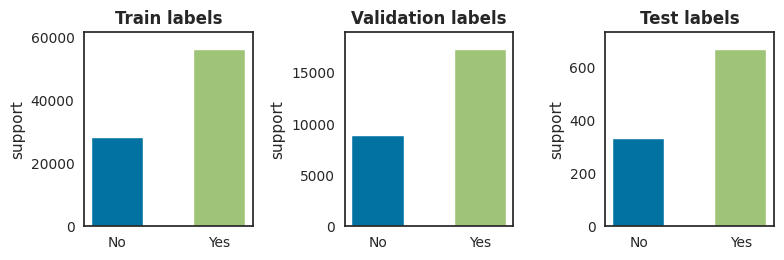

In [136]:
plot_class_balances({"train": y_train, "validation": y_val, "test": y_test})


## Rule-based sentiment analysis

Rule-based approaches to perform sentiment analysis typically rely traditional NLP techniques such as parsing, stemming, tokenization, part-of-speech tagging and lexical analysis to perform sentiment analysis. 

Two well-known programs to perform rule-based sentiment analysis are [VADER](https://github.com/cjhutto/vaderSentiment) **[Hutto & Gilbert, 2014]** and [Textblob](https://textblob.readthedocs.io/en/dev/) **[Loria, 2018]**, which we will further present and evaluate in the next two paragraphs.

Because those rule-based sentiment analysis algorithms typically do not need to get trained first on a training data set, we will run both VADER and Textblob immediately on the drug reviews in the test set.

### Vader


> VADER (Valence Aware Dictionary and sEntiment Reasoner) is a lexicon and rule-based sentiment analysis tool that is specifically attuned to sentiments expressed in social media.

(taken from [https://github.com/cjhutto/vaderSentiment](https://github.com/cjhutto/vaderSentiment))

After running VADER on the test data set, we will get a list with polarity scores and sentiments for all drug reviews in the test set. We will store those results in a dataframe, which will be used for further analysis later.

In [137]:
analyzer = SentimentIntensityAnalyzer()
vs_result_list = []
for sentence in tqdm(test_df['review'].tolist()):
    vs = analyzer.polarity_scores(sentence)
    vs_result_list.append(vs)

100%|██████████| 1000/1000 [00:01<00:00, 865.65it/s]


In [138]:
vs_dict = defaultdict(list)

for vs in vs_result_list:
    label = "POSITIVE" if vs["compound"] > 0 else "NEGATIVE"
    vs_dict["vader_neg"].append(vs["neg"])
    vs_dict["vader_neu"].append(vs["neu"])
    vs_dict["vader_pos"].append(vs["pos"])
    vs_dict["vader_polarity"].append(vs["compound"])
    vs_dict["vader_label"].append(label)
    emoji = HAPPY if vs["compound"] >= 0 else SAD
    vs_dict["vader_sentiment"].append(emoji)

vader_df = pd.DataFrame(vs_dict, index=test_df.index)
vader_df.head()


,vader_neg,vader_neu,vader_pos,vader_polarity,vader_label,vader_sentiment
patient_id,,,,,,
163740,0.204,0.629,0.167,-0.5267,NEGATIVE,😡
206473,0.040,0.802,0.158,0.7539,POSITIVE,🙂
39293,0.036,0.884,0.080,0.6810,POSITIVE,🙂
97768,0.036,0.825,0.139,0.9559,POSITIVE,🙂
208087,0.065,0.802,0.133,0.6924,POSITIVE,🙂


### Textblob

> TextBlob is a Python (2 and 3) library for processing textual data. It provides a simple API for diving into common natural language processing (NLP) tasks such as part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, translation, and more.

(taken from [https://textblob.readthedocs.io/en/dev/])

Although Textblob is a general NLP library, it also provides functionality to perform [sentiment analysis](https://textblob.readthedocs.io/en/dev/quickstart.html#sentiment-analysis) and to compute polarity scores form text. Similar to VADER we will also run the TextBlob sentiment analysis algorithm to compute polarity scores for all drug reviews in the test set, which we will store in a dataframe as well.

In [139]:
textblob_scores = []
for doc in tqdm(test_df["review"].tolist()):
    doc = (
        doc.translate(string.punctuation)
        .replace(".", "")
        .replace("\n", "")
        .replace("!", "")
        .replace("?", "")
    )
    blob = TextBlob(doc)
    
    for sentence in blob.sentences:
        textblob_scores.append(sentence.sentiment.polarity)


100%|██████████| 1000/1000 [00:01<00:00, 927.12it/s]


In [140]:
tb_dict = defaultdict(list)

for tb in textblob_scores:
    label = "POSITIVE" if tb >= 0 else "NEGATIVE"
    tb_dict["textblob_polarity"].append(tb)
    tb_dict["textblob_label"].append(label)
    emoji = HAPPY if tb >= 0 else SAD
    tb_dict["textblob_sentiment"].append(emoji)

textblob_df = pd.DataFrame(tb_dict, index=test_df.index)
textblob_df.head()

,textblob_polarity,textblob_label,textblob_sentiment
patient_id,,,
163740,0.000000,POSITIVE,🙂
206473,0.566667,POSITIVE,🙂
39293,0.139063,POSITIVE,🙂
97768,0.234537,POSITIVE,🙂
208087,0.341667,POSITIVE,🙂


### Interlude: Vader vs. Textblob, a polarity comparison

As a small interlude, let's have a look how the polarity scores from VADER and Textblob compare to each other. First we will take the VADER and Textblob vectors with polarity scores and we will compute the Pearson correlation coeficient between both vectors.

In [180]:
pcc = np.corrcoef(vader_df["vader_polarity"], textblob_df["textblob_polarity"])[1,0]
print(f"Pearson correlation coefficient: {pcc}")

Pearson correlation coefficient: 0.4983856937129934


The Pearson correlation percent is 0.5, indicating no statistical relationship between both variables.
Let's also visualize the polarity scores for both classifiers and how they relate to each other. From the graph we can observe that the VADER polarity scores seem to be more negative, whereas the Textblob scores have a more positive polarity.

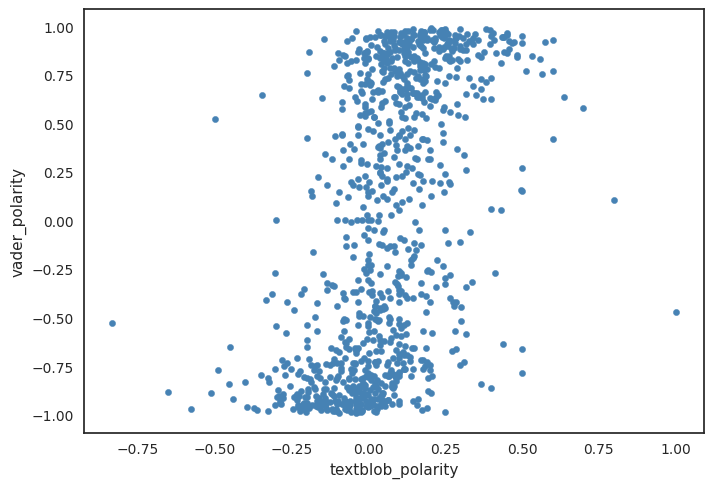

In [175]:
pd.concat(
    [vader_df["vader_polarity"], textblob_df["textblob_polarity"]], axis=1
).plot.scatter(x="textblob_polarity", y="vader_polarity", c='steelblue');


## Feature-based sentiment analysis

Besides rule-based sentiment analysis, we can also perform feature-based sentiment analysis. To perform feature-based sentiment analysis we will transform the text of the drug reviews into a numerical representation. We can then use this numerical representation as a feature vector and train some classifiers to learn to predict some sentiment labels.


To convert the drug reviews into numerical vectors we will use *term frequency–inverse document frequency (TF-IDF)* scores. For the sentiment classification task, we will use some well-known classifiers such as *Naive Bayes*, *Logistic Regression* and *Support Vector Machins* (SVM).

So let's get started with the feature extraction and compute the TF-IDF scores.



### Feature extraction (TF-IDF)

The TF-IDF score for a word $i$ in a document $j$ can be computed as follows:

$TF-IDF = tf_(i,j) \times log(\frac{N}{df_i})$

Where

* $tf_(i,j)$ = number of occurences of $i$ in document $j$
* $df_i$ =  number of documents containing $i$
* $N$ = total number of documents

Although we could use a simple bag-of-word model or term frequences, we will use TF-IDF as it conveys some information about the importance of a word in a corpus (and hence it's feature importance).

To compute the TD-IDF scores, we will use Scikit-learn's [TdidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html).


In [141]:
tf_idf = TfidfVectorizer(ngram_range=(1, 3), binary=True, smooth_idf=False)
X_train_tfidf = tf_idf.fit_transform(X_train)
X_val_tfidf = tf_idf.transform(X_val)
X_test_tfidf = tf_idf.transform(X_test)

Now that we have compute TT-ID scores we can train the different classifier models using the TF-IDF scores from the traing set and the associated labels we have created earlier.

Before training the selected classifiers, we will define some auxiliary functions that will compute and visualize model performance.

In [142]:
def fit_model(model, prefix):

    model.fit(X_train_tfidf, y_train)
    pred = model.predict(X_test_tfidf)

    sentiment = [HAPPY if x=="POSITIVE" else SAD for x in pred]

    df = pd.DataFrame(
        {f"{prefix}_label": pred, f"{prefix}_sentiment": sentiment}, index=test_df.index
    )
    
    return df

In [143]:
y_train_bin = np.array([1 if x=="POSITIVE" else 0 for x in y_train])
y_test_bin = np.array([1 if x=="POSITIVE" else 0 for x in y_test])


def plot_performance(model):
    fig = plt.figure(figsize=(14, 14))
    fig, axes = plt.subplots(2, 2)

    cl = ["NEGATIVE", "POSITIVE"]
    visualgrid = [
        ClassPredictionError(model, classes=cl, ax=axes[0][0]),
        ConfusionMatrix(model, classes=cl, ax=axes[0][1]),
        ClassificationReport(model, classes=cl, ax=axes[1][0]),
        ROCAUC(model, classes=cl, ax=axes[1][1], binary=True),
    ]

    for viz in visualgrid:
        viz.fit(X_train_tfidf, y_train_bin)
        viz.score(X_test_tfidf, y_test_bin)
        viz.finalize()

    plt.tight_layout()
    plt.show()


### Naive Bayes Classifier

As a first classifier, we will train a Naive Bayes Classifier. Note that we set some weighted class prioers because the class labels are unbalanced.

<Figure size 1400x1400 with 0 Axes>

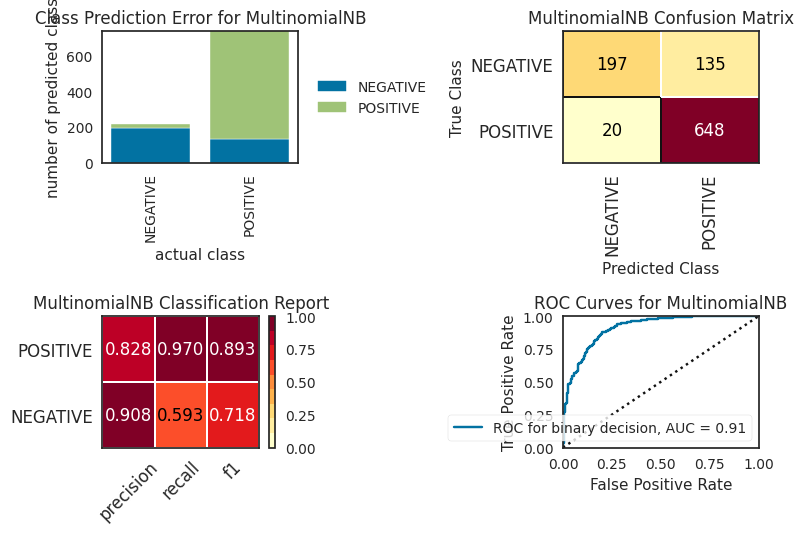

In [144]:
nb_model = MultinomialNB(class_prior=[0.9, 0.1])
plot_performance(nb_model)

In [145]:
nb_df = fit_model(nb_model, prefix='nb')
nb_df.head(10)

,nb_label,nb_sentiment
patient_id,,
163740,POSITIVE,🙂
206473,POSITIVE,🙂
39293,POSITIVE,🙂
97768,POSITIVE,🙂
208087,NEGATIVE,😡
215892,POSITIVE,🙂
169852,POSITIVE,🙂
23295,POSITIVE,🙂
71428,NEGATIVE,😡


### Logistic regression

Similarly, we will train a logistic regression model.

<Figure size 1400x1400 with 0 Axes>

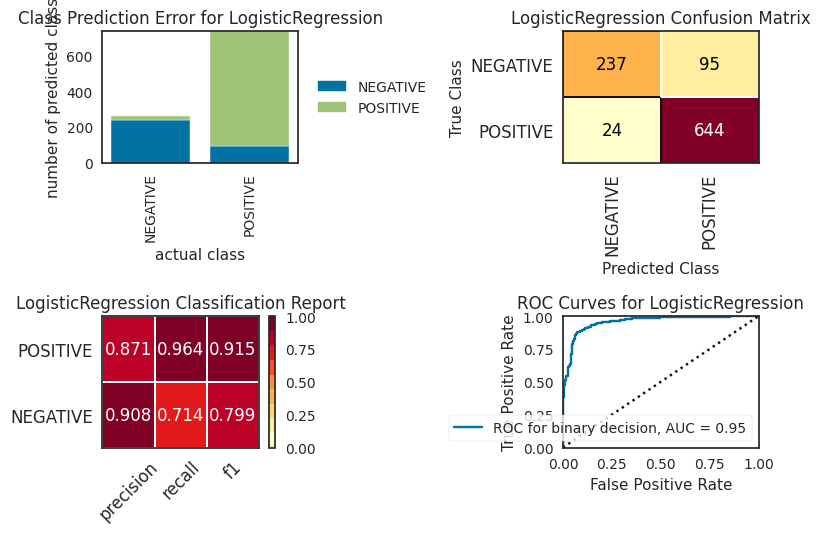

In [146]:
lr_model = LogisticRegression(solver='liblinear', multi_class='auto')
plot_performance(lr_model)

In [147]:
lr_df = fit_model(lr_model, prefix='lr')
lr_df.head(10)

,lr_label,lr_sentiment
patient_id,,
163740,POSITIVE,🙂
206473,POSITIVE,🙂
39293,POSITIVE,🙂
97768,POSITIVE,🙂
208087,POSITIVE,🙂
215892,NEGATIVE,😡
169852,POSITIVE,🙂
23295,POSITIVE,🙂
71428,NEGATIVE,😡


### Support Vector Machines

As a final machine learning model, we will fit a SVM classifier. Because SVMs do not scale well with the number of training examples (i.e they have quadratic runtime complexity) we will only train the SVM on the first 10000 drug reviews. So we will train the SVM with a custom pipeline. 

In [148]:
svm_pipeline = Pipeline(
    [
        ('vectorizer', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SVC(kernel='linear', C=1, class_weight='balanced')) 
    ]
)

In [149]:
NR_EXAMPLES = 10000
svm_clf = svm_pipeline.fit(
    train_df.head(NR_EXAMPLES)["review"], train_df.head(NR_EXAMPLES)["actual_label"]
)


In [150]:
svm_pred = svm_clf.predict(test_df["review"])
svm_sentiment = [HAPPY if x == "POSITIVE" else SAD for x in svm_pred]
svm_df = pd.DataFrame(
    {"svm_label": svm_pred, "svm_sentiment": svm_sentiment}, index=test_df.index
)
svm_df.head(10)

,svm_label,svm_sentiment
patient_id,,
163740,POSITIVE,🙂
206473,POSITIVE,🙂
39293,POSITIVE,🙂
97768,POSITIVE,🙂
208087,POSITIVE,🙂
215892,NEGATIVE,😡
169852,POSITIVE,🙂
23295,POSITIVE,🙂
71428,NEGATIVE,😡


# Embedding-based sentiment analysis

Another approach to perform sentiment analysis is to use word embeddings. We can embed the words in the drug reviews using pretrained language models and then train a transformer model to predict the sentiment labels from the word embeddings. Compared to the previous TF-IDF + classifier approach, we will not only have more context from the language model embeddings, but we will also have more sentence context because BERT models are bidirectional. So possibly this emmbeding approach could improve sentiment predictions compared to previous approach.

To create the word embeddings we will use the [Flair NLP](https://github.com/flairNLP/flair) library, which will download the pretrained language model and subsequently will create the embeddings and transformer model. Flair uses  *sentiment-en-mix-distillbert_4* as a pretrained language model. This language model is based on the [distilbert](https://huggingface.co/docs/transformers/model_doc/distilbert) language model and was further fine-tuned for performing sentiment analysis.




In [151]:
classifier = TextClassifier.load('en-sentiment')

2023-02-24 02:50:21,026 loading file /home/ubuntu/.flair/models/sentiment-en-mix-distillbert_4.pt


In [163]:
fl_pred = []
for doc in tqdm(test_df["review"].tolist()):
    
    doc = (
        doc.translate(string.punctuation)
        .replace(".", "")
        .replace("\n", "")
        .replace("!", "")
        .replace("?", "")
    )
    
    sentence = Sentence(doc)
    classifier.predict(sentence)
    fl_pred.append(sentence.labels[0].to_dict()['value'])
    
fl_sentiment = [HAPPY if x == "POSITIVE" else SAD for x in fl_pred]
    
fl_df = pd.DataFrame(
    {"db_label": fl_pred, "db_sentiment": fl_sentiment}, index=test_df.index
)

fl_df.head(10)
    

100%|██████████| 1000/1000 [05:12<00:00,  3.20it/s]


,db_label,db_sentiment
patient_id,,
163740,POSITIVE,🙂
206473,POSITIVE,🙂
39293,POSITIVE,🙂
97768,POSITIVE,🙂
208087,NEGATIVE,😡
215892,NEGATIVE,😡
169852,POSITIVE,🙂
23295,NEGATIVE,😡
71428,NEGATIVE,😡


## Model comparison

Now that we have run all our models, we are finally ready to compare and evaluate model performance of the various classifiers.

### Merge results

We already have all those model scores computed on the test for all classifiers, so let's put everything together in one data frame to facilitate further comparisons.

In [153]:
results_df = pd.concat(
    [
        test_df[["review", "stars", "rating", "actual_label", "actual_sentiment"]],
        vader_df[["vader_label", "vader_polarity", "vader_sentiment"]],
        textblob_df[["textblob_sentiment", "textblob_label", "textblob_polarity"]],
        lr_df[["lr_sentiment", "lr_label"]],
        nb_df[["nb_sentiment", "nb_label"]],
        fl_df[["fl_sentiment", "fl_label"]],
        svm_df[["svm_sentiment", "svm_label"]],        
    ],
    axis=1,
)

We will also add additional columns with binary labels, as it will make it easier to score the model predictions later on.

In [181]:
label_cols = results_df.filter(regex=("_label")).columns.to_list()

for l in label_cols:
    new = l.replace('label', 'binlabel')
    results_df[new] = [
        1 if x == "POSITIVE" else 0 for x in results_df[l]
    ]

results_df.filter(regex=("_binlabel")).head()


,actual_binlabel,vader_binlabel,textblob_binlabel,lr_binlabel,nb_binlabel,fl_binlabel,svm_binlabel
patient_id,,,,,,,
163740,1,0,1,1,1,1,1
206473,1,1,1,1,1,1,1
39293,1,1,1,1,1,1,1
97768,1,1,1,1,1,1,1
208087,0,1,1,1,0,0,1


After merging all results, we can have a look at the predictions made by all classifiers.

In [164]:
selected_cols = results_df.filter(regex=("_sentiment")).columns.to_list()
display(results_df[selected_cols].head(10).style.hide(axis="index"))


actual_sentiment,vader_sentiment,textblob_sentiment,lr_sentiment,nb_sentiment,fl_sentiment,svm_sentiment
🙂,😡,🙂,🙂,🙂,🙂,🙂
🙂,🙂,🙂,🙂,🙂,🙂,🙂
🙂,🙂,🙂,🙂,🙂,🙂,🙂
🙂,🙂,🙂,🙂,🙂,🙂,🙂
😡,🙂,🙂,🙂,😡,😡,🙂
😡,😡,😡,😡,🙂,😡,😡
🙂,🙂,🙂,🙂,🙂,🙂,🙂
🙂,🙂,🙂,🙂,🙂,😡,🙂
😡,😡,😡,😡,😡,😡,😡
😡,😡,😡,😡,😡,😡,😡


### Create confusion matrices

To make it easier to compare model performance for all classifiers we will create a large image that combines all confusion matrices for the individual classifiers into a single graph.

In [157]:
labels = [0, 1]

clf_dict = {
    'vader': 'Vader Sentiment',
    "textblob": 'TextBlob',
    "lr": "Logistic Regression",
    'nb': "Naive Bayes",
    'svm': "SVM",
    'fl': 'DistilBERT'
}

cm_dict = {}
for k, v in clf_dict.items():
    new = k + "_binlabel"
    cm_dict[k] = confusion_matrix(
        results_df["actual_binlabel"], results_df[new], labels=labels
    )

In [182]:
def plot_confusion_matrix(
    cf_matrix,
    cmap="RdPu",
    font_color="steelblue",
    edge_color="violet",
    title="Confusion Matrix",
    xlab="Predicted",
    ylab="Actual",
):
    group_names = [
        "True Negatives",
        "False Positives",
        "False Negatives",
        "True Positives",
    ]
    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = [
        "{0:.2%}".format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)
    ]
    labels = [
        f"{v1}\n\n{v2} ({v3})"
        for v1, v2, v3 in zip(group_names, group_counts, group_percentages)
    ]
    labels = np.asarray(labels).reshape(2, 2)
    axis_labels = ["Negative", "Positive"]
    fig = sns.heatmap(
        cf_matrix,
        annot=labels,
        xticklabels=axis_labels,
        yticklabels=axis_labels,
        fmt="",
        linewidths=0.5,
        clip_on=False,
    )
    for tick_label in fig.axes.get_xticklabels():
        tick_label.set_color(font_color)
        tick_label.set_fontsize("12")
    for tick_label in fig.axes.get_yticklabels():
        tick_label.set_color(font_color)
        tick_label.set_fontsize("12")
    fig.collections[0].colorbar.set_label(
        "Counts", fontweight="bold", color=font_color, labelpad=-30, y=1.06, rotation=0
    )
    plt.setp(
        plt.getp(fig.collections[0].colorbar.ax.axes, "yticklabels"), color=font_color
    )
    plt.xlabel(xlab, fontweight="bold", fontsize=16, color=font_color)
    plt.ylabel(ylab, fontweight="bold", fontsize=16, color=font_color)
    plt.title(title, fontweight="bold", fontsize=20, color=font_color)

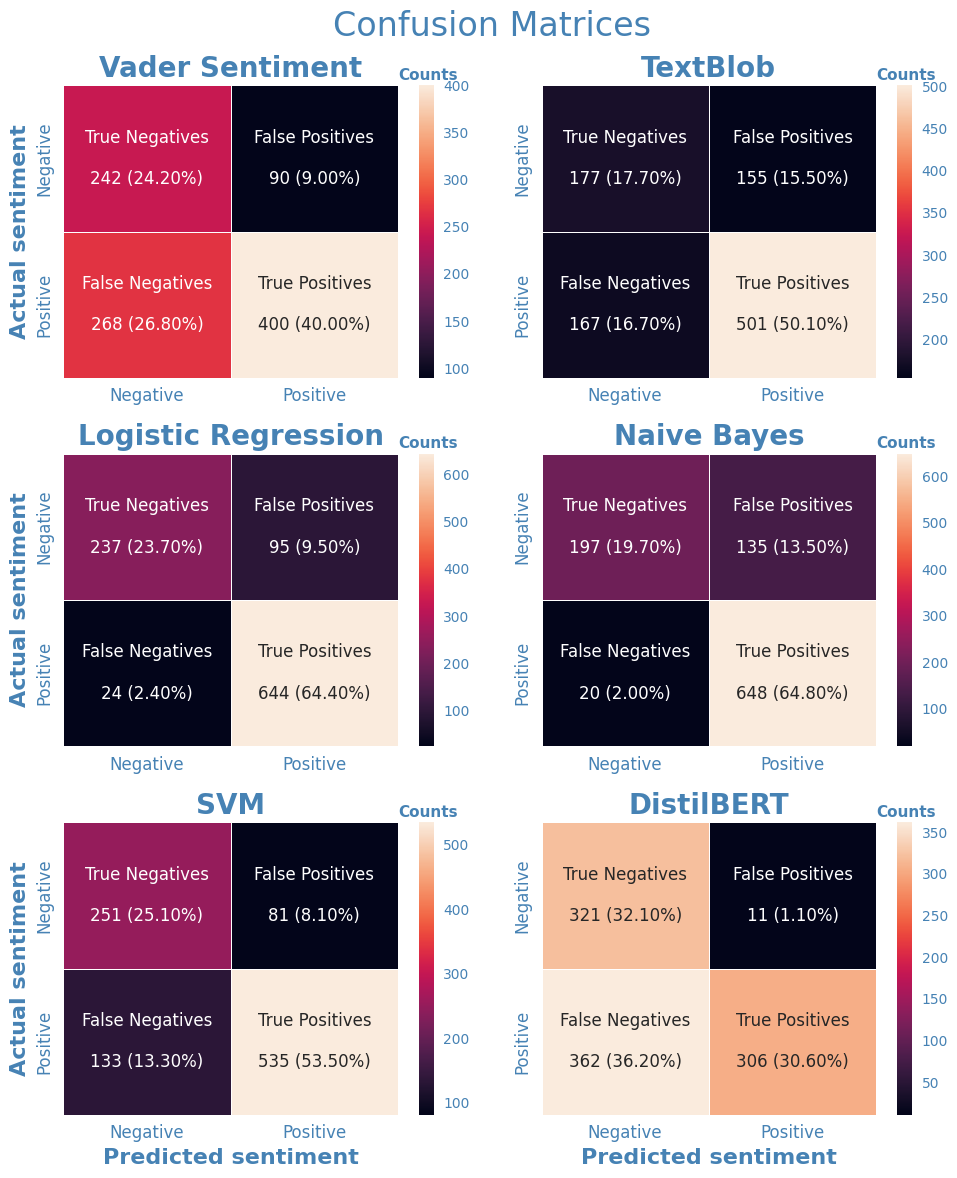

In [183]:
fig = plt.figure(figsize=(10,12))
fig.subplots_adjust(hspace=0.4, wspace=1.4)
fig.suptitle("Confusion Matrices", fontsize=24, color="steelblue")

for i, (k,v) in enumerate(cm_dict.items()):
    
    ax = fig.add_subplot(3, 2, (i+1))
    x_lab = "Predicted sentiment" if (i+1) in (5,6) else ""
    y_lab = "Actual sentiment" if (i+1) % 2 == 1 else ""
    plot_confusion_matrix(
        v,
        title=clf_dict[k],
        xlab=x_lab,
        ylab=y_lab,
    )
plt.tight_layout()


2023-02-18 18:04:16,731 https://nlp.informatik.hu-berlin.de/resources/models/sentiment-curated-distilbert/sentiment-en-mix-distillbert_4.pt not found in cache, downloading to /tmp/tmpt2_kvm49

### Compute performance metrics

We will also create the following meterics to have a more global view of individual classifier performance:

* **Precision:** $${\displaystyle \frac {\text{|TP|}} {\text{|TP|+|FP|}} }$$

* **Recall:** $${\displaystyle \frac {\text{|TP|}} {\text{|TP|+|FN|}} }$$

* **f1 score:** $${\displaystyle {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}}$$

* **Jaccard index:** $${\displaystyle J(A,B) = {{|A \cap B|}\over{|A \cup B|}} = {{|A \cap B|}\over{|A| + |B| - |A \cap B|}}}$$



In [160]:
scores_df = pd.DataFrame(columns=("Classifier", "Precision", "Recall", "F1", "AUC", "Jaccard"))

for i, (k, v) in enumerate(clf_dict.items()):
    bin_label = k + "_binlabel"
    prf = precision_recall_fscore_support(
        results_df["actual_binlabel"], results_df[bin_label], average="weighted"
    )
    precision, recall, f1, _ = prf

    auc = roc_auc_score(
        results_df["actual_binlabel"], results_df[bin_label], average="weighted"
    )
    
    jac = jaccard_score(
        results_df["actual_binlabel"], results_df[bin_label], average="weighted"
    )

    scores_df.loc[i] = [v, precision, recall, f1, auc, jac]

#scores_df.set_index('Classifier', inplace=True)
scores_df.style.hide(axis='index')


Classifier,Precision,Recall,F1,AUC,Jaccard
Vader Sentiment,0.702843,0.642000,0.652326,0.663859,0.486413
TextBlob,0.680990,0.678000,0.679399,0.641566,0.524408
Logistic Regression,0.883598,0.881000,0.876879,0.838964,0.784839
Naive Bayes,0.854229,0.845000,0.834908,0.781717,0.724865
SVM,0.797173,0.786000,0.789438,0.778461,0.656351
DistilBERT,0.800855,0.627000,0.625036,0.712476,0.454605


Finally, we can plot the above metrics for all classifiers.

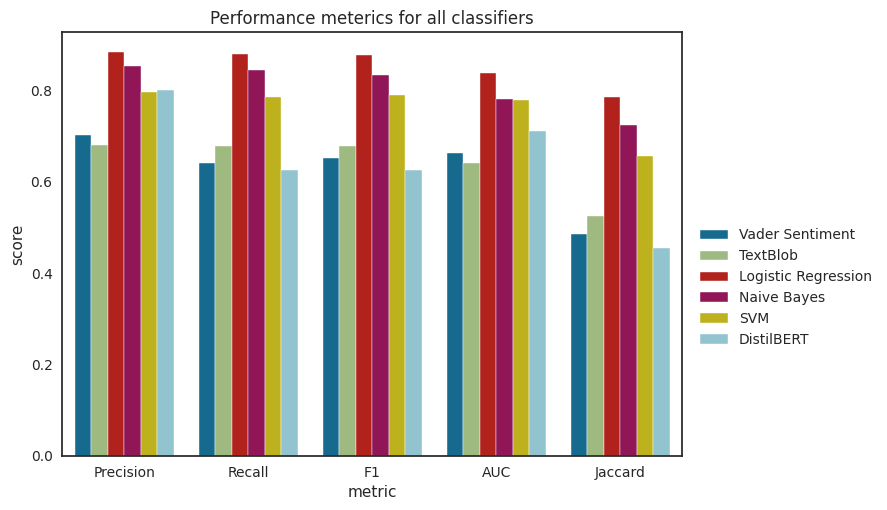

In [184]:
scores_long = scores_df.melt(id_vars=["Classifier"], 
                var_name='metric',
                value_vars=['Precision', 'Recall', 'F1', 'AUC', 'Jaccard'],
                value_name='score')

sns.barplot(data=scores_long, x='metric', y="score", hue="Classifier")
plt.legend(bbox_to_anchor=(1.02, 0.55), loc='upper left', borderaxespad=0);
plt.title("Performance meterics for all classifiers");

## Conclusion

We can observe from the comparison graph that the logistic regression classifier has the best performance across all metrics. Overal feature-based methods seem to have the best out-of-the-box performance, outperforming rule-and embedding-based methods. For the rule-based methods, VADER and Textblob exhibited similar performance. Somewhat surprisingly, the embedding-based model did not outperform the other feature-based classifiers, but exhibited similar performance as the rule-based methods. It should be noted though that we used a sentiment analysis model that was trainined on the IMDB movie reviews data set. So, this data set might not be entirely representative. Becaue we were only interested in out-of-the-box performance for the scopoe of this study, we did not fine-tune the model further. However, it is expected that further finetuning the model on our training set with drug reviews will result in performance gains.

## References





* **Hutto, C., & Gilbert, E.** (2014, May). Vader: A parsimonious rule-based model for sentiment analysis of social media text. In Proceedings of the international AAAI conference on web and social media (Vol. 8, No. 1, pp. 216-225).

* **Loria, S.** (2018). textblob Documentation. Release 0.15, 2(8).
